In [1]:
# Make necessary imports
import pydicom as dicom
import matplotlib.pylab as plt
import cv2
import os
import math
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

## Visualise original CT and Effusion Scans

In [2]:
# Original Folder
ct_folder = '../Pleural-Effusion/raw_data/ct_scans'
effusion_folder = '../Pleural-Effusion/raw_data/effusion_masks'

# Files
file_name = 'LUNG1-001'

# Read .nii files
ct_scan = nib.load(os.path.join(ct_folder, f'{file_name}.nii'))
effusion_mask = nib.load(os.path.join(effusion_folder, f'{file_name}_effusion.nii'))

# Get imaging data
ct_data = ct_scan.get_fdata()
effusion_data = effusion_mask.get_fdata()

print(ct_data.shape, effusion_data.shape)

(512, 512, 134) (512, 512, 134)


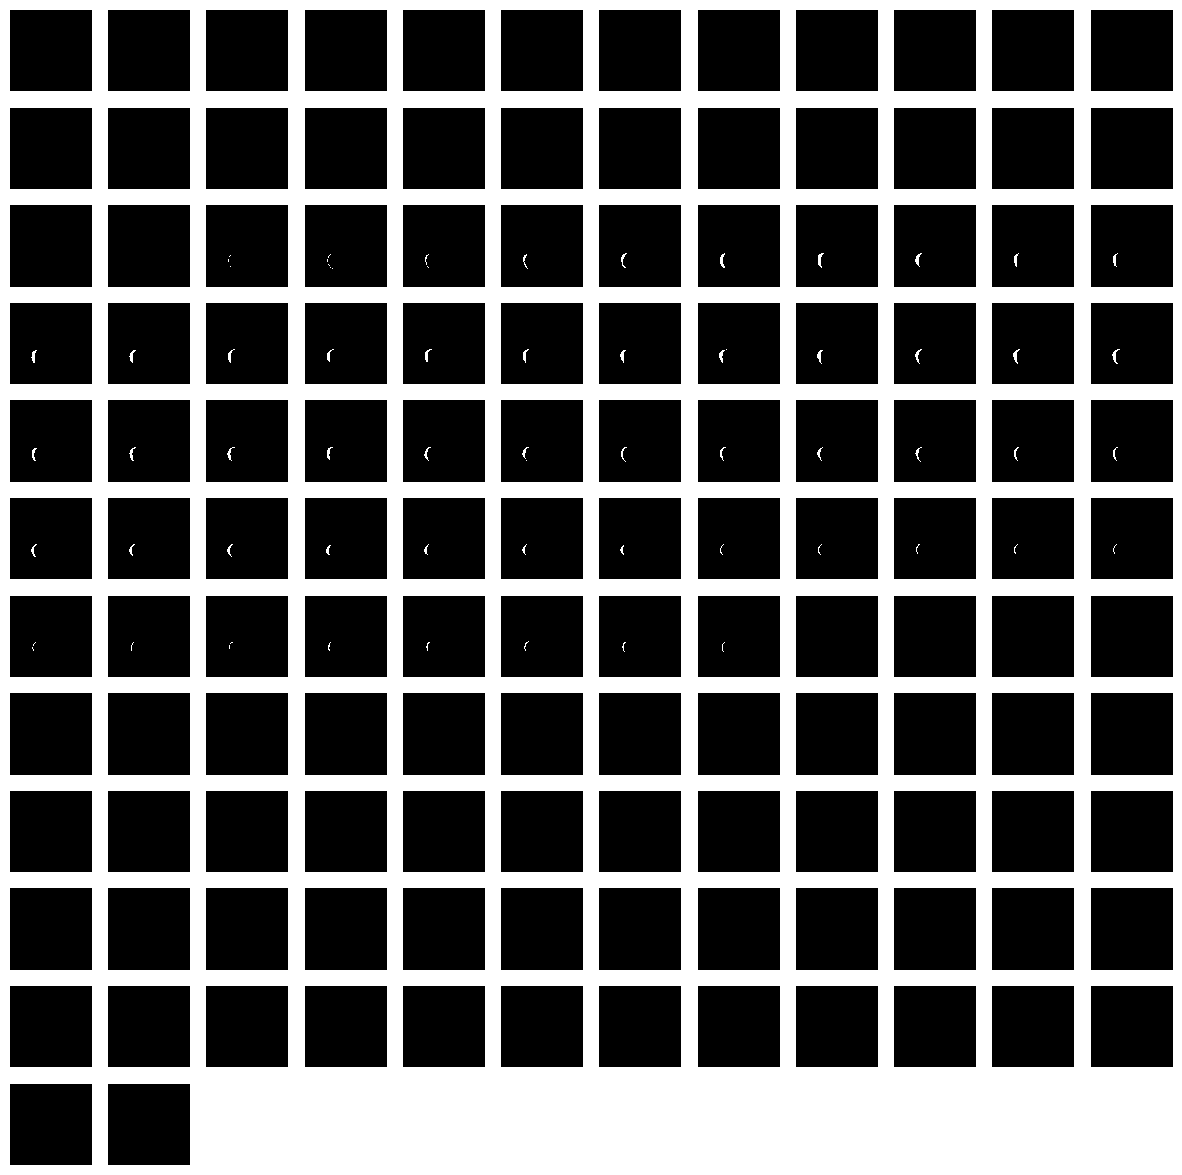

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_channel_grid(scan_data):
    # Get the dimensions of the 3D scan
    depth, height, num_channels = scan_data.shape

    # Calculate the number of rows and columns in the grid
    num_rows = int(np.ceil(np.sqrt(num_channels)))
    num_cols = int(np.ceil(num_channels / num_rows))

    # Plot the square grid of images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

    for i in range(num_rows):
        for j in range(num_cols):
            channel_idx = i * num_cols + j

            if channel_idx < num_channels:
                # Plot the channel image
                axes[i, j].imshow(scan_data[:, :, channel_idx], cmap='gray', interpolation='nearest')
                axes[i, j].axis('off')
            else:
                # Hide empty subplots
                axes[i, j].axis('off')

    plt.show()

plot_channel_grid(effusion_data)

## Visualise Preprocessed Data

In [4]:
# Paths after dividing into traint test split
preprocess_train_path = '../Pleural-Effusion/preprocessed_data/training_data'
preprocess_test_path = '../Pleural-Effusion/preprocessed_data/testing_data'

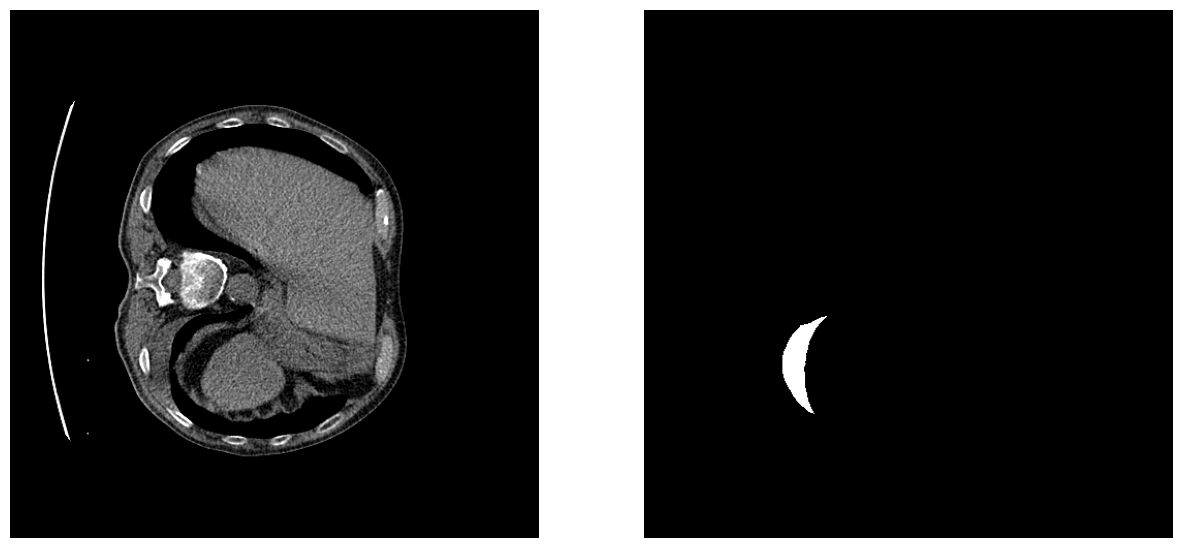

In [5]:
# Load data
preprocess_data_filename = 'LUNG1-001_slice34.npz'
preprocess_data = np.load(os.path.join(preprocess_train_path, preprocess_data_filename))

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(preprocess_data['image'], cmap = 'gray')
axes[1].imshow(preprocess_data['label'], cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')

plt.show()

## Visualize Segmented Part

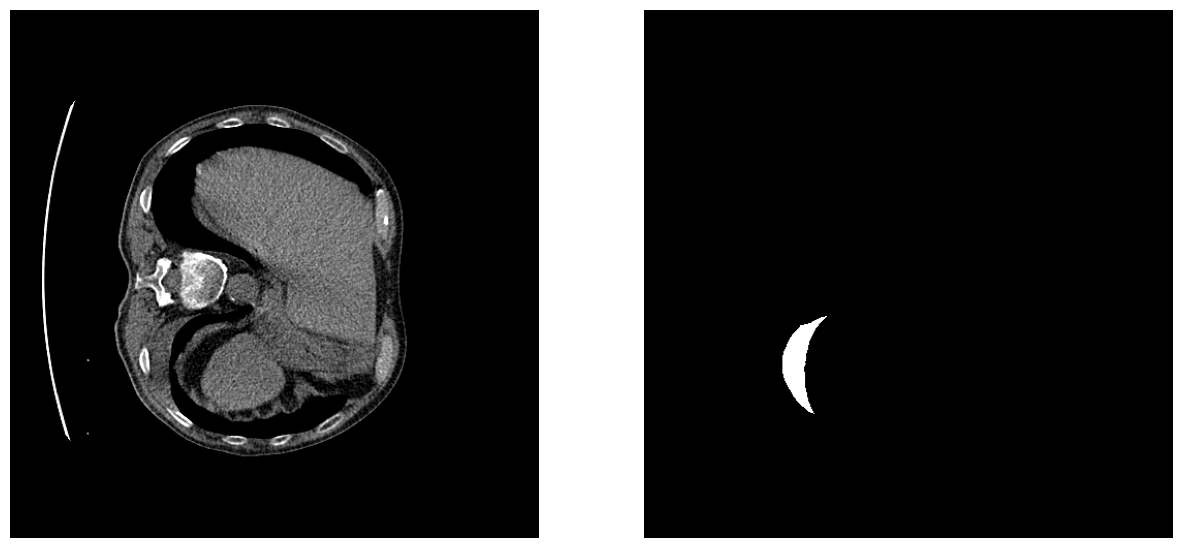

In [6]:
# Load images as greyscale but make main RGB so we can annotate in colour
seg  = np.ascontiguousarray(preprocess_data['label']*255).astype(np.uint8)
main = np.ascontiguousarray(preprocess_data['image']*255).astype(np.uint8)

# Create subplot
fig, axes = plt.subplots(1, 2, figsize=(15, 15))
axes[0].imshow(main, cmap = 'gray')
axes[1].imshow(seg, cmap = 'gray')
axes[0].axis('off')
axes[1].axis('off')

plt.show()

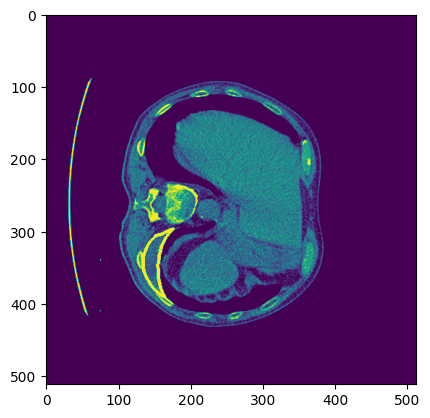

In [8]:
# Dictionary giving RGB colour for label (segment label) - label 1 in red, label 2 in yellow
RGBforLabel = { 1:(0,0,255), 2:(0,255,255) }

# Find external contours
contours,_ = cv2.findContours(seg,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

# Iterate over all contours
for i,c in enumerate(contours):
    # Find mean colour inside this contour by doing a masked mean
    mask = np.zeros(seg.shape, np.uint8)
    cv2.drawContours(mask,[c],-1,255, -1)
    # DEBUG: cv2.imwrite(f"mask-{i}.png",mask)
    mean,_,_,_ = cv2.mean(seg, mask=mask)
    # DEBUG: print(f"i: {i}, mean: {mean}")

    # Get appropriate colour for this label
    label = 2 if mean > 1.0 else 1
    colour = RGBforLabel.get(label)
    # DEBUG: print(f"Colour: {colour}")

    # Outline contour in that colour on main image, line thickness=1
    cv2.drawContours(main,[c],-1,(255, 0, 0), 3)

# Save result
plt.imshow(main)